# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import glob
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import read_diagrams, create_labeled_classes, bin_class_loss, multi_class_loss, bin_class_acc, multi_class_acc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
#workload = "small"
workload = "medium"
#workload = "large"

classification = 2
layers = 1
single_qubit_params = 3
n_wire_count = 2

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Lambeq optimizer

In [5]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Total number of circuits:  121
Total number of variables:  163


In [6]:
training_data_labels_l = np.array(training_data_labels_l)
test_data_labels_l = np.array(test_data_labels_l)
validation_data_labels_l = np.array(validation_data_labels_l)

## Model

In [7]:
parameters = sorted(
    train_syms,
    key=default_sort_key)

In [8]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

train_pred_fn = jit(make_pred_fn(training_circuits_l))
dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
test_pred_fn = make_pred_fn(test_circuits_l)

## Loss function and evaluation

In [9]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [10]:
EPOCHS = 1000
SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
init_params_spsa = np.array(rng.random(len(parameters)))
numpy.random.seed(SEED)

train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

def callback_fn(xk):
    valid_loss = dev_cost_fn(xk)
    train_loss = round(train_costs[-1], 4)
    train_acc = round(train_accs[-1], 4)
    valid_acc = round(dev_accs[-1], 4)
    iters = int(len(train_accs)/2)
    if iters % 100 == 0:
        print(
                #f"Params = {xk}, "
                f"Epoch: {iters}   ",
                f"train/loss: {train_loss}   ",
                f"valid/loss: {round(valid_loss, 4)}   ",
                f"train/acc: {train_acc}   ",
                f"valid/acc: {valid_acc}"
            )
    return valid_loss

Epoch: 100    train/loss: 25.801799774169922    valid/loss: 7.491699695587158    train/acc: 0.375    valid/acc: 0.1429
Epoch: 200    train/loss: 25.69059944152832    valid/loss: 7.5864996910095215    train/acc: 0.3875    valid/acc: 0.1905
Epoch: 300    train/loss: 25.044898986816406    valid/loss: 7.173499584197998    train/acc: 0.45    valid/acc: 0.2857
Epoch: 400    train/loss: 23.347299575805664    valid/loss: 7.030299663543701    train/acc: 0.525    valid/acc: 0.3333
Epoch: 500    train/loss: 22.550899505615234    valid/loss: 7.432499885559082    train/acc: 0.5375    valid/acc: 0.4762
Epoch: 600    train/loss: 23.381999969482422    valid/loss: 6.62339973449707    train/acc: 0.525    valid/acc: 0.619
Epoch: 700    train/loss: 22.251298904418945    valid/loss: 8.128399848937988    train/acc: 0.525    valid/acc: 0.5238
Epoch: 800    train/loss: 22.403398513793945    valid/loss: 6.704799652099609    train/acc: 0.525    valid/acc: 0.4286
Epoch: 900    train/loss: 21.782400131225586    v

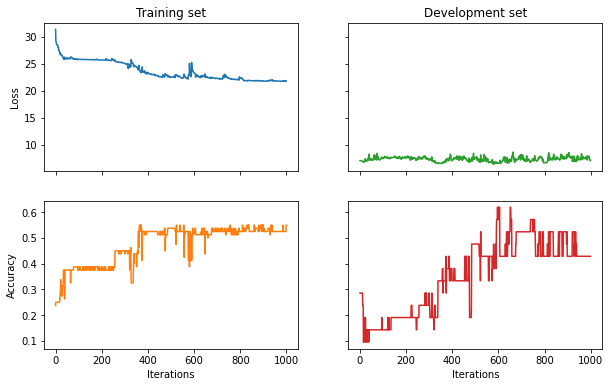

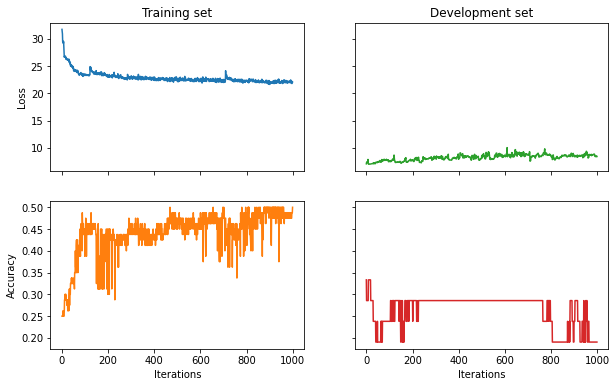

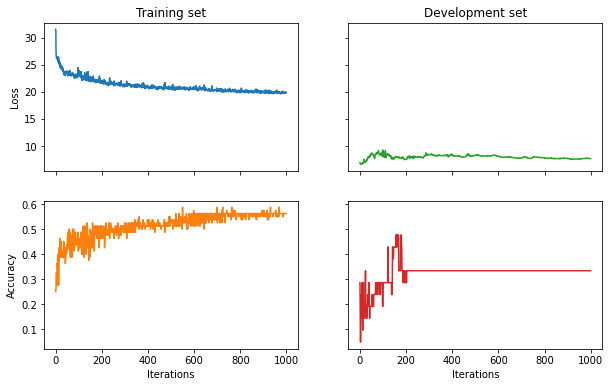

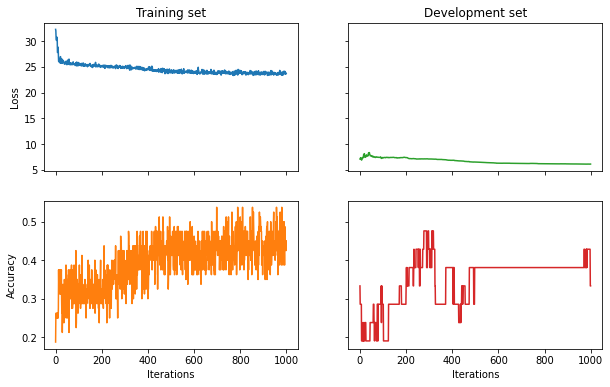

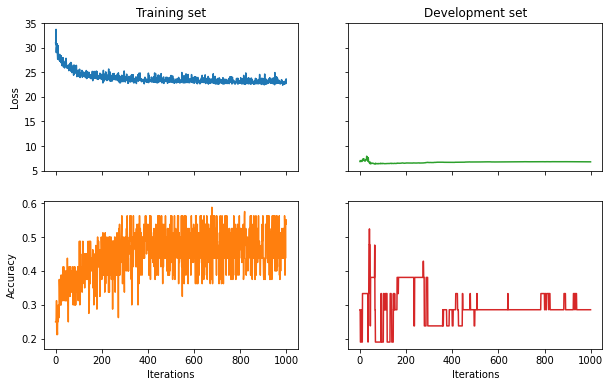

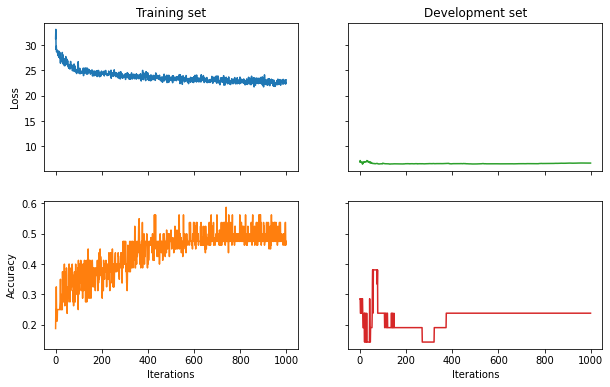

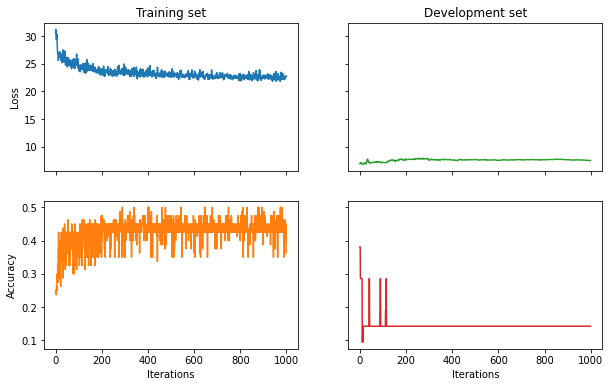

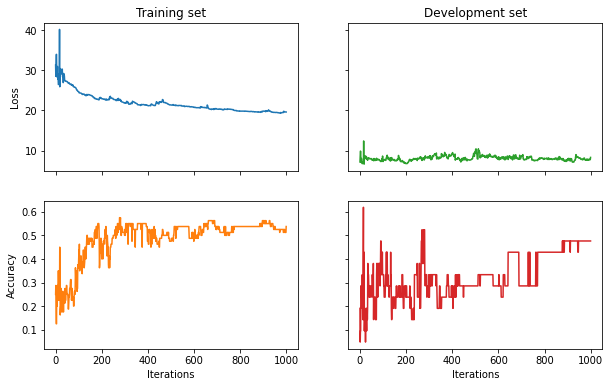

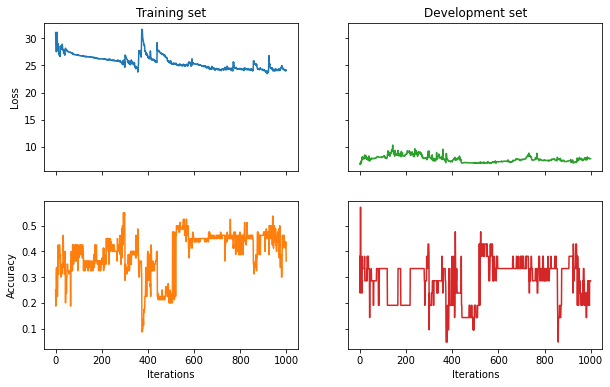

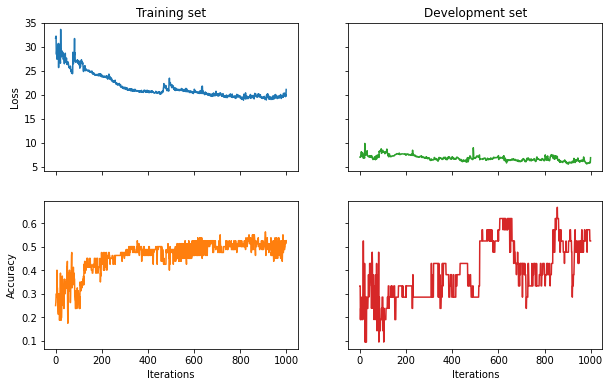

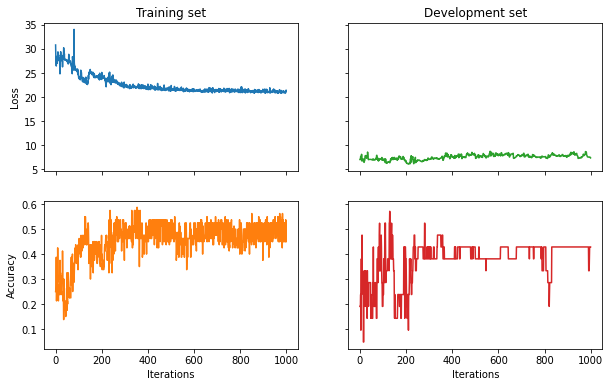

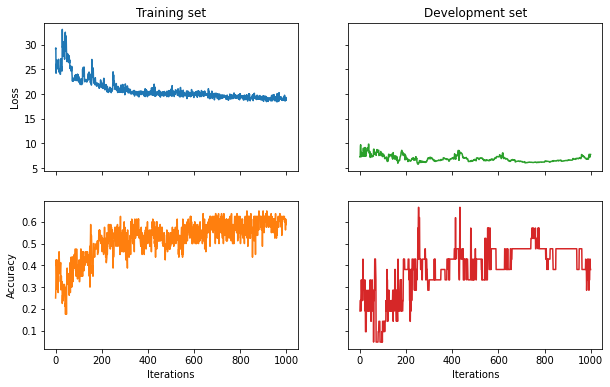

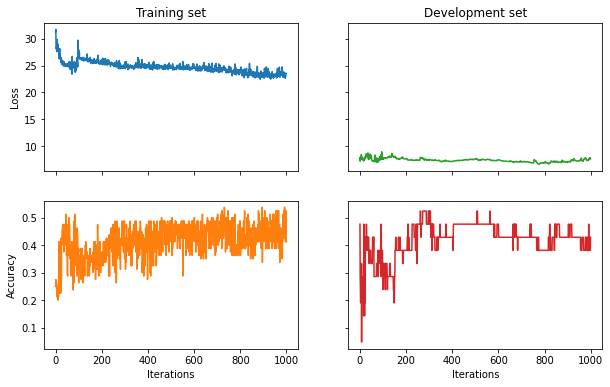

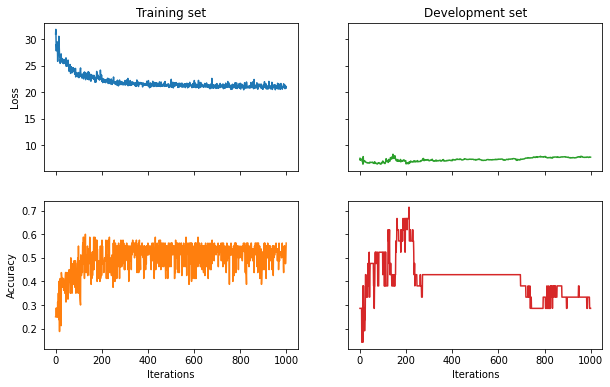

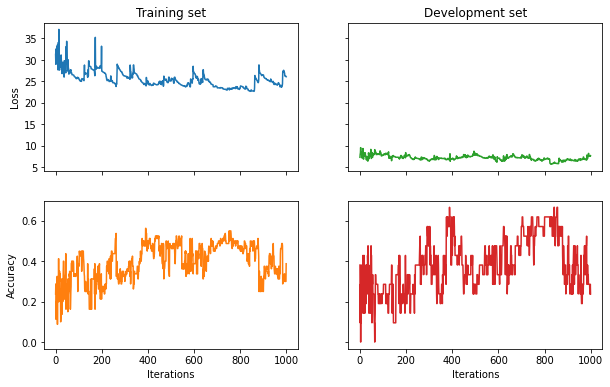

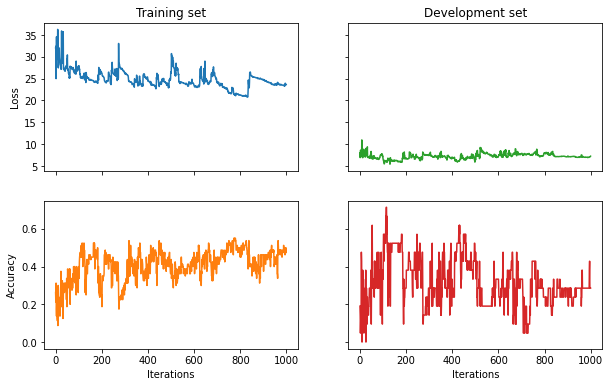

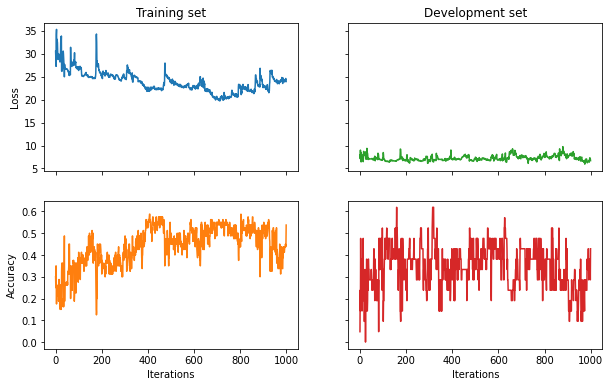

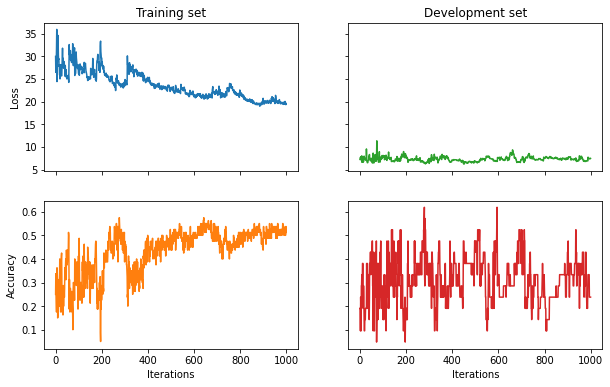

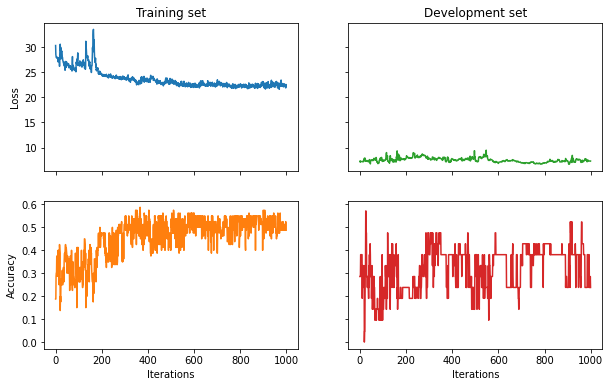

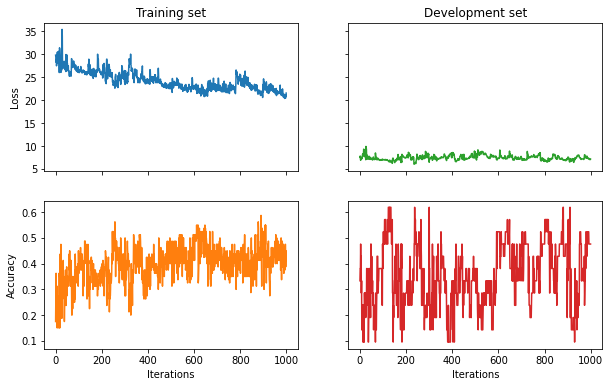

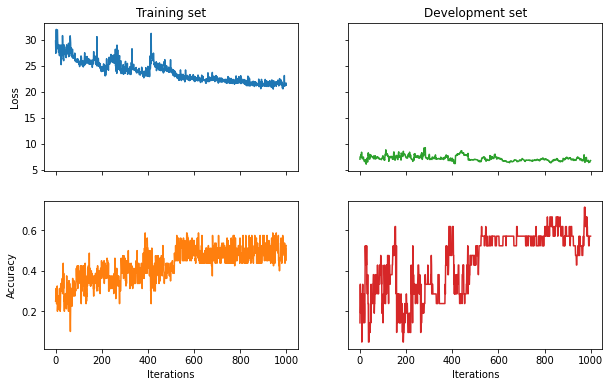

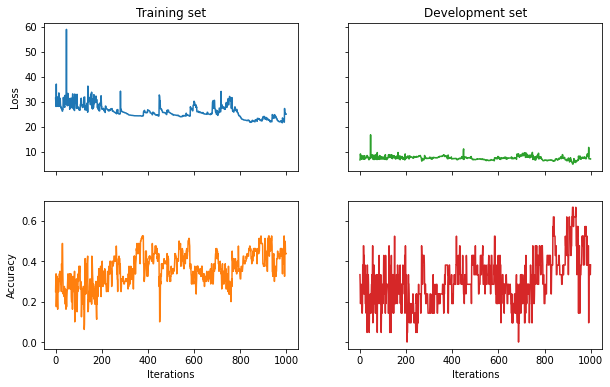

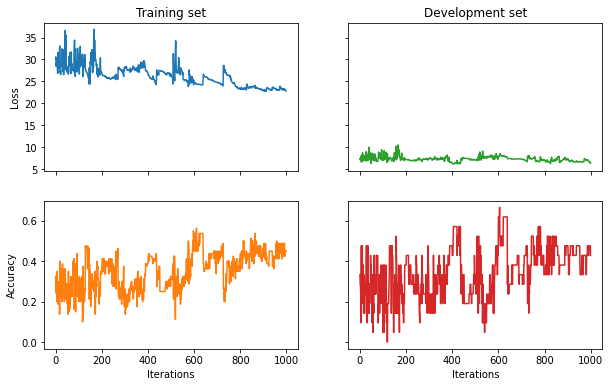

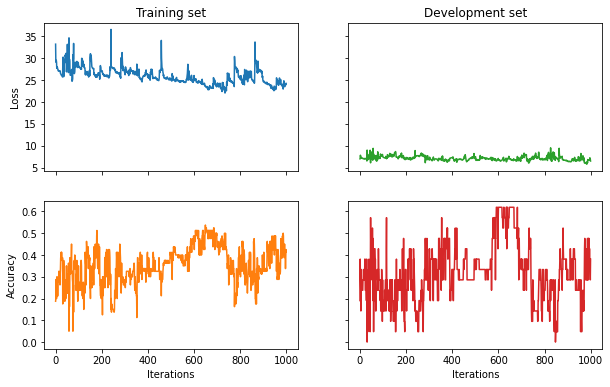

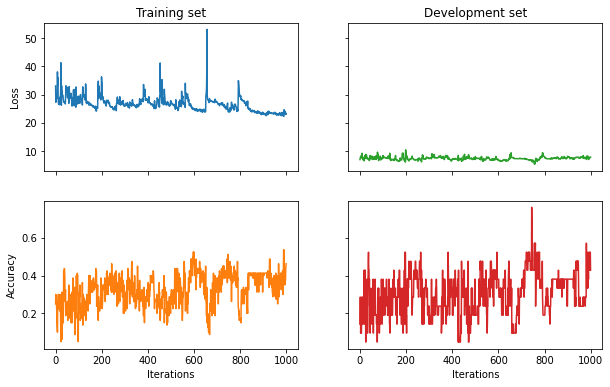

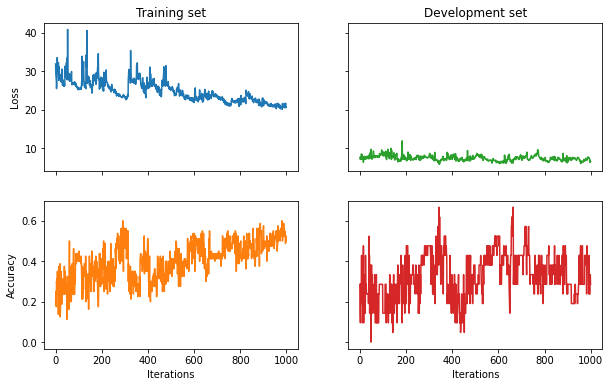

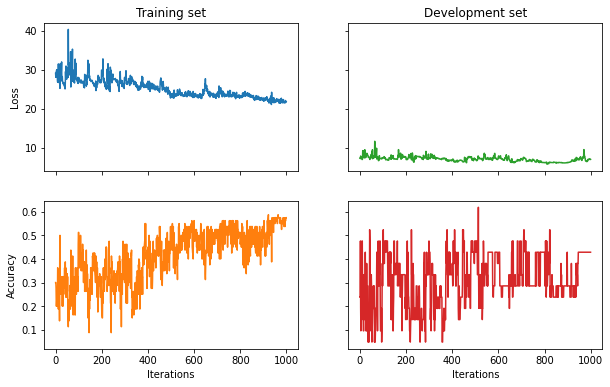

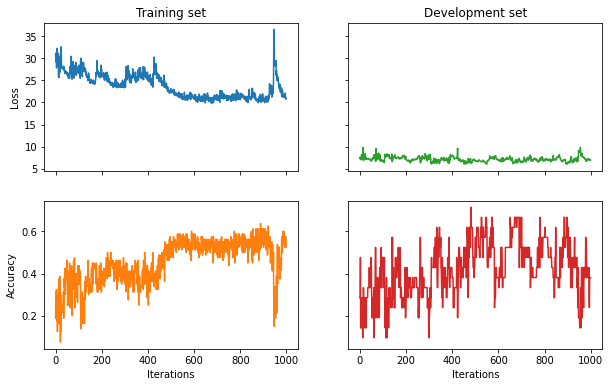

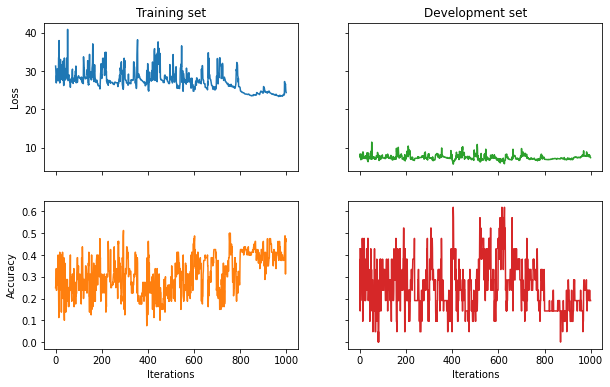

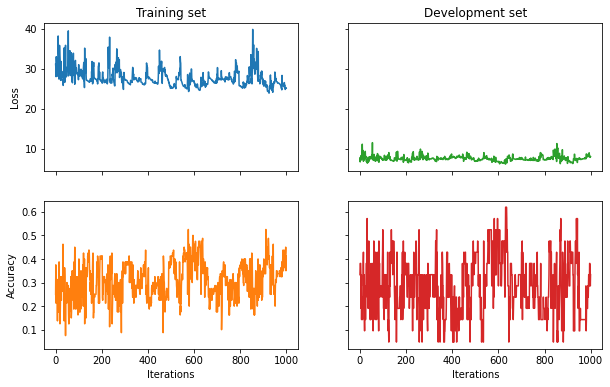

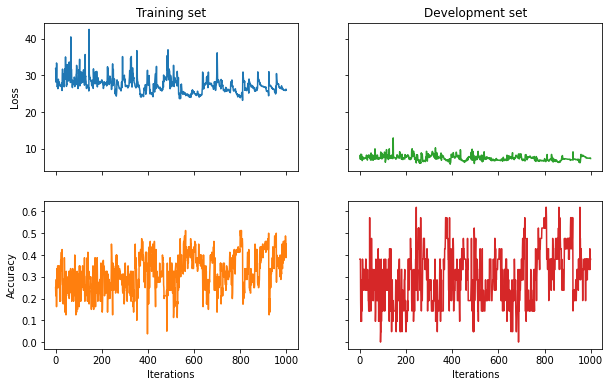

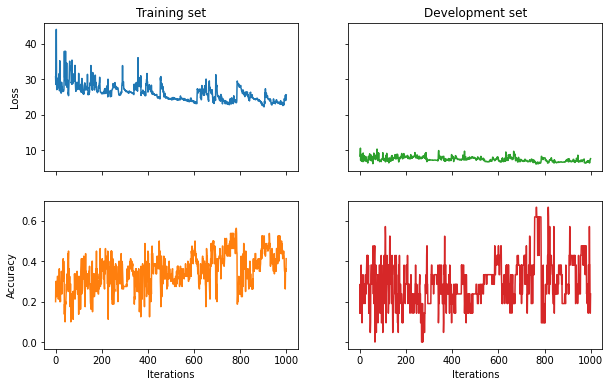

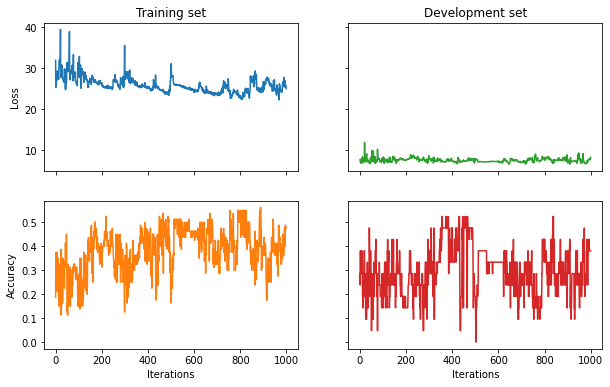

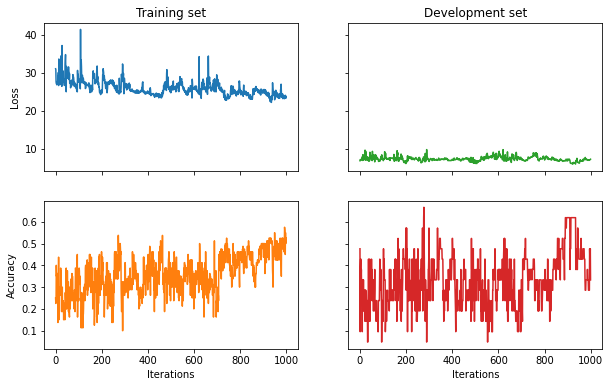

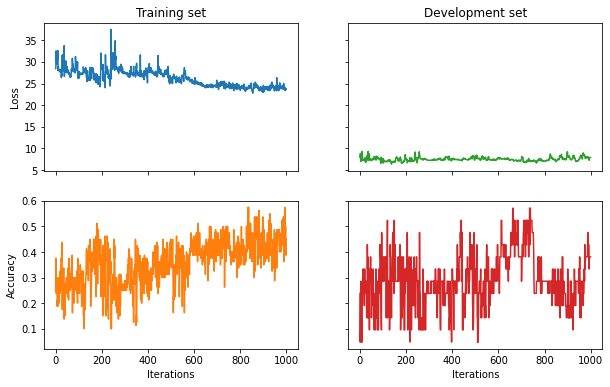

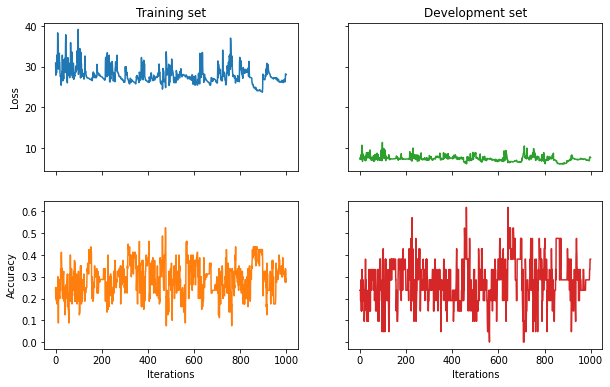

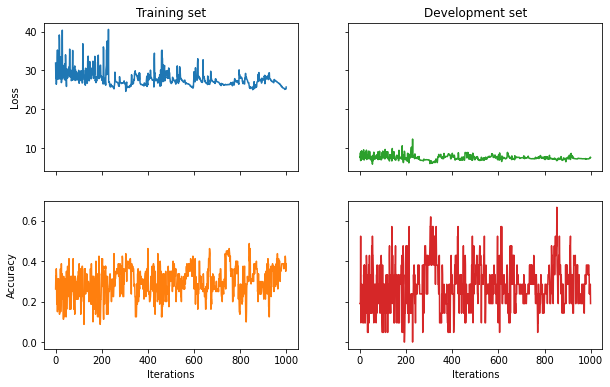

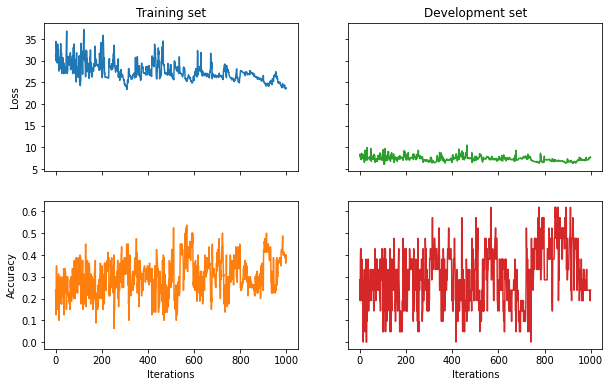

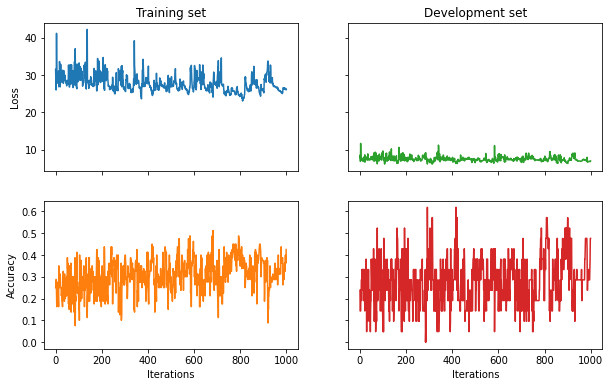

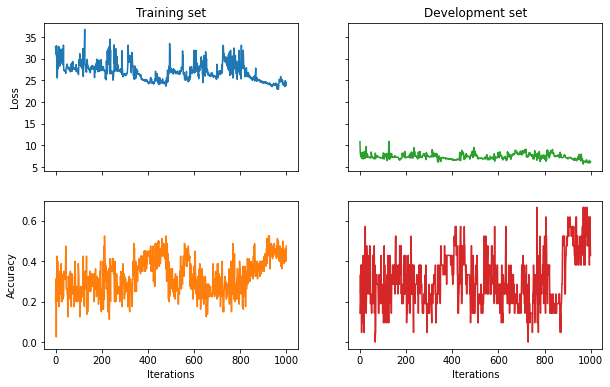

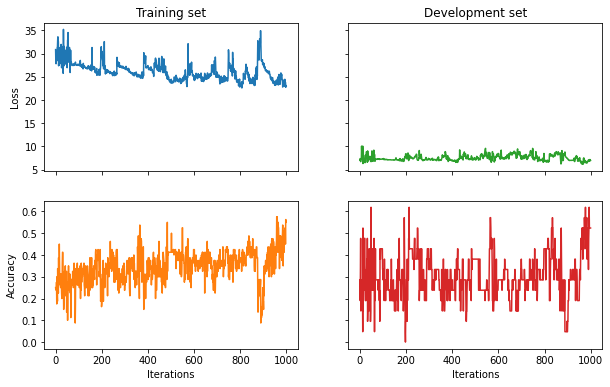

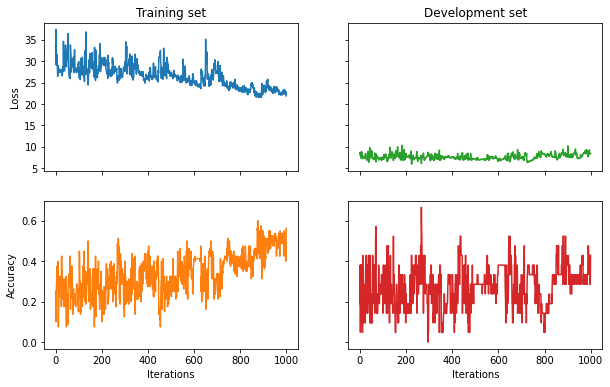

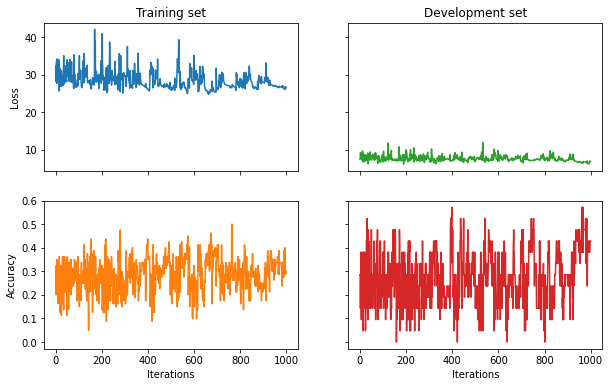

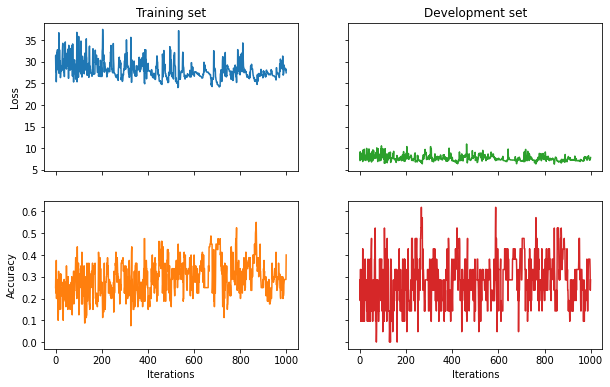

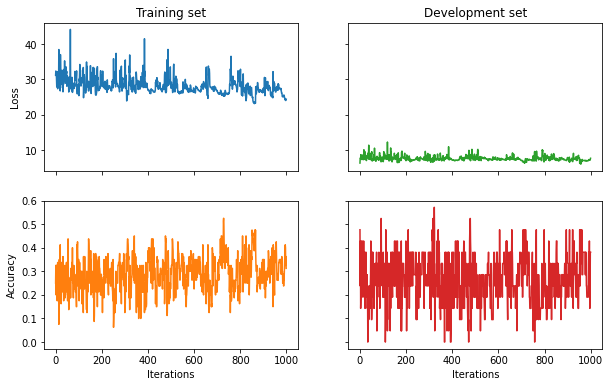

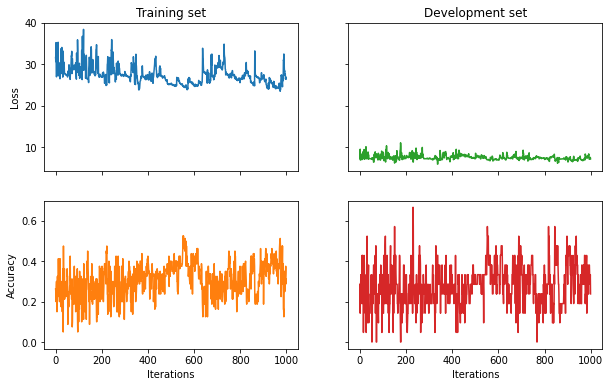

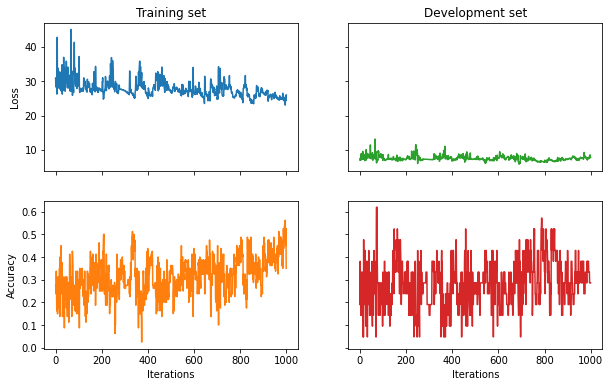

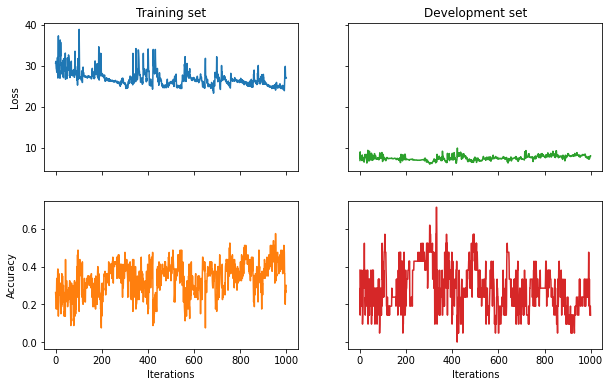

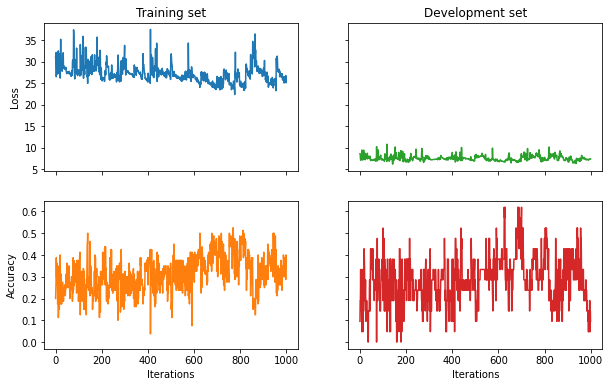

In [11]:
#a_values = [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
#c_values = [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

a_values = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
c_values = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
for i, a_value in enumerate(a_values):
    for j, c_value in enumerate(c_values):
        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
        
        result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
        
        print("a: ", a_value)
        print("c: ", c_value)
        print(result)
        
        fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
        ax_tl.set_title('Training set')
        ax_tr.set_title('Development set')
        ax_bl.set_xlabel('Iterations')
        ax_br.set_xlabel('Iterations')
        ax_bl.set_ylabel('Accuracy')
        ax_tl.set_ylabel('Loss')

        colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
        ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
        ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
        ax_tr.plot(dev_costs, color=next(colours))
        ax_br.plot(dev_accs, color=next(colours))

        # print test accuracy
        test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_data_labels_l)
        test_cost_fn(result.x)
        print('Test accuracy:', test_accs[0])

        plt.savefig(this_folder + "//results//" + workload + "_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params) + "_" + str(i) + "_" + str(j) + ".png") 

Test accuracy: 0.25


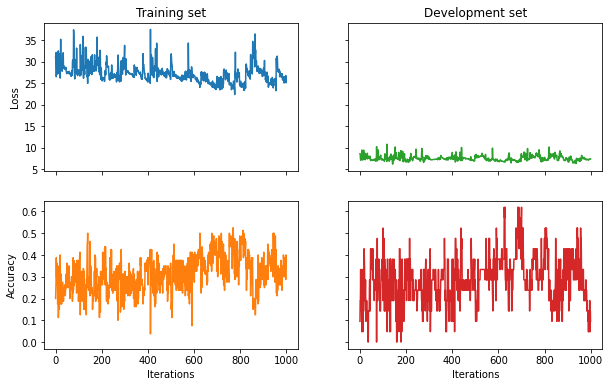

In [12]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_data_labels_l)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])

plt.savefig(this_folder + "//results//" + workload + "_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params) + ".png") 